# Теория

Уменьшение/сокращение размерности --  задача из машинного обучения (изначально -- из статистики), где алгоритм "собирает" многочисленные признаки в высокоуровневые абстракции.
Основная задача --  уменьшить количество измерений в наборе данных (датасете), сохраняя его основные характеристики.

В NLP сокращение размерности важно, потому что текстовые данные часто являются высокомерными(имеют много признаков), что делает их обработку и анализ сложными.

Применив уменьшение размерности на данных, можно:
- снизить вычислительную сложность выбранного алгоритма
- повысить производительности ML-модели
- хорошо визуализировать данные

**Где используется уменьшение размерности:**<br>
- Рекомендательные системы
- Риск-менеджмент
- Красивые визуализации
- Определение похожих текстов (тематическое моделирование)


**Популярные алгоритмы:** <br>
- Метод главных компонент (PCA)
- Сингулярное разложение (SVD/LSA)
- Латентное размещение Дирихле (LDA)
- Матричный факторизационный анализ(NMF)
- t-SNE, UMAP (для визуализации)

Преимущества и недостатки различных методов

- PCA является вычислительно эффективным и легким в интерпретации, но он предполагает линейные отношения в данных
- LSA и NMF полезны для выявления скрытых тем в текстовых данных, но могут быть чувствительны к выбору параметров и менее интерпретируемы, чем PCA
- t-SNE полезен для визуализации многомерных данных, но он не очень подходит для извлечения признаков

Как выбирать соответствующий метод? В зависимости от конкретной задачи.

PS: Уменьшение размерности также работает для определения тематик текстов (Topic Modelling). Датасет текстами представляют как некоторую абстракцию из более низкоуровневых признаков.

# Практика

Сегодня будем делать тематическое моделирование на [корпусе отзывов с TripAdvizer](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)


In [124]:
# viz
import matplotlib.pyplot as plt
import seaborn as sns

# векторизация текстов
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# dimred
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF 

# other
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [151]:
# зададим несколько переменных, будем использовать их как параметры функций

n_samples = 2000 # размер корпуса
n_features = 1000 # максимальное количество слов в матрице "документы х слова" (= top1000 частотных их всех в корпусе)
n_components = 5 # число тем в корпусе
n_top_words = 20 # порог частотности для визуализаций

Сначала загрузим датасет

In [126]:
data = pd.read_csv("tripadvisor_hotel_reviews.csv")
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Всего в датасете около 20К отзывов,  но для работы мы возьмем часть датасета: первые 2К отзывов

In [97]:
# первые N документов

data_samples = data[:n_samples] 
print("Общий датасет = {} текстов;\nФрагмент для работы = {} текстов".format(len(data),len(data_samples)))


data_samples.head()

Общий датасет = 20491 текстов;
Фрагмент для работы = 2000 текстов


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


Теперь, для дальнейшей работы с текстами, их надо векторизовать

In [130]:
# достанем тексты, превратим в лист, где элемент -- это отдельный текст отзыва
reviews_as_list = data_samples.Review.to_list()
len(reviews_as_list)

2000

In [152]:
tf_vectorizer = CountVectorizer(max_df=0.7, min_df=5, # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')

X_tf = tf_vectorizer.fit_transform(reviews_as_list)

###  ```X_tf``` - это матрица "документы x слова". Она - основной элемент сегодняшних экспериментов. С помощью моделей снижения размерности, мы будем преобразовывать ее в другие матрицы

In [134]:
display(X_tf.shape) # матрица "документы x слова" 

tf_vectorizer.get_feature_names()[700:720] # посмотрим на слова с 700 по 720е, например

(2000, 1000)

['queen',
 'questions',
 'quick',
 'quickly',
 'quiet',
 'quite',
 'rate',
 'rates',
 'read',
 'reading',
 'ready',
 'real',
 'really',
 'reason',
 'reasonable',
 'reasonably',
 'received',
 'recent',
 'recently',
 'reception']

### Данные подготовлены! Теперь можно пробовать алгоритмы уменьшения размерности

наши алгоритмы : 
- LDA (Latent Dirichlet Allocation)
- SVD (Single Value Decomosition)
- NMF (Non-negative Matrix Factorization)

### Почему они?

LDA (Latent Dirichlet Allocation), LSA (Latent Semantic Analysis) и NMF (Non-negative Matrix Factorization) широко используются для тематического моделирования, потому что они эффективны в выявлении и извлечении латентных тем из больших и сложных наборов данных(корпусов).

- LDA - это вероятностная модель, которая предполагает, что документы порождаются из смеси тем, и каждая тема - это распределение слов. 
- LSA (больше известная как SVD) -- это техника разложения матрицы на 3 составляющие. Она преобразует большую матрицу (слова x документы) в пространство меньшей размерности, что позволяет выявить скрытые темы. 
- NMF - это еще одна техника факторизации матриц, которая, подобно LSA, извлекает скрытые темы из матрицы встречаемости слов, но с дополнительным ограничением на неотрицательность всех значений матрицы(фичей).

Все три метода эффективны в выявлении латентных тем и показывают высокое качество результатов в различных приложениях, таких как информационный поиск, кластеризация документов и анализ тональности. Они также относительно просты в реализации и имеют имплементацию в sklearn, которую мы сегодня попробуем.

## LDA
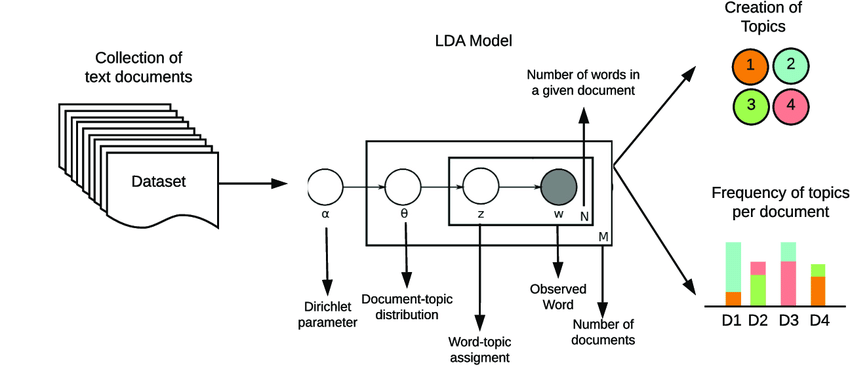
- Корпус -- это коллекция из D документов.

- Документ состоит из N слов.

- В одном документе может встретиться K тем.

Слова в корпусе -- единственная явная переменная. Скрытые (латентные) переменные - это распределение тем в корпусе и распределение слов в документе. Задача алгоритма LDA -- используя наблюдаемые слова извлечь информацию о структуре тем в корпусе.

Для LDA нужны две матрицы: *“темы x слова"*  и  *“документы x темы”*. 
Они получаются из матрицы "документы x слова" (именно она у нас есть)

Основные шаги, необходимые для выполнения LDA:

1. Выберем количество тем K, которые должна обнаружить модель.
2. Случайным образом назначим каждому слову в каждом документе одну из K тем.
3. Повторим для каждого слова в каждом документе и вычислим вероятность того, что слово принадлежит каждой из K тем, учитывая текущие назначения тем для всех остальных слов в документе.
4. Назначим каждому слову новую тему на основе вычисленных вероятностей.
5. Повторим шаги 3-4 до достижения сходимости.
6. После сходимости модель выводит две матрицы: ```документы х темы```  и ```темы х слова```.  Распределение документов по темам указывает на вероятность того, что каждый документ принадлежит каждой из K тем, а распределение тем по словам указывает на вероятность того, что каждая тема генерирует каждое слово в корпусе.

LDA имеет множество применений, включая кластеризацию документов, информационный поиск и анализ тональности.

**Что такое "сходимость" ?**

В LDA сходимость достигается, когда темы, назначенные для каждого слова в корпусе перестают существенно меняться после каждой итерации.

Другими словами, после каждой итерации LDA вычисляет вероятность того, что каждое слово принадлежит каждой из K тем, учитывая текущие назначения тем для всех остальных слов в корпусе. Затем модель назначает каждому слову новую тему на основе этих вероятностей. Если изменение этих вероятностей между итерациями достаточно мало, то назначения тем стабилизировались, и модель достигла сходимости.

Сходимость важна в LDA, потому что она гарантирует, что модель обнаружила стабильный набор тем, которые являются представительными для корпуса. Если модель не сошлась, то темы могут быть нестабильными и не отражать действительность.

Достижение сходимости в LDA может быть вычислительно интенсивным процессом и может потребовать запуска модели многократно. Количество итераций, необходимых для достижения сходимости, может зависеть от размера и сложности набора данных, а также от выбранных гиперпараметров модели.

##  Сейчас попробуем алгоритм LDA:

параметры в скобках: 
- n_components: число тем в корпусе
-  max_iter: количество итераций алгоритма
- learning_offset: параметр, который занижает значение ранних итераций (тк более важная часть обучения случается на поздних), обычно устанавливается больше чем 1 

[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#examples-using-sklearn-decomposition-latentdirichletallocation)

In [157]:
# может занять время
lda = LatentDirichletAllocation(n_components=2, max_iter=50,learning_offset=10)

lda.fit(X_tf)

LatentDirichletAllocation(learning_offset=10, max_iter=50, n_components=2)

In [145]:
# матрица "темы x слова"
lda.components_.shape


(5, 1000)

### Что за темы  получились, и что за слова в них присутствуют?
Давайте используем функцию для упрощения визуализации топа частотности по темам:  

In [146]:
def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 15)) # параметры отображения 
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1] 
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь
        
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

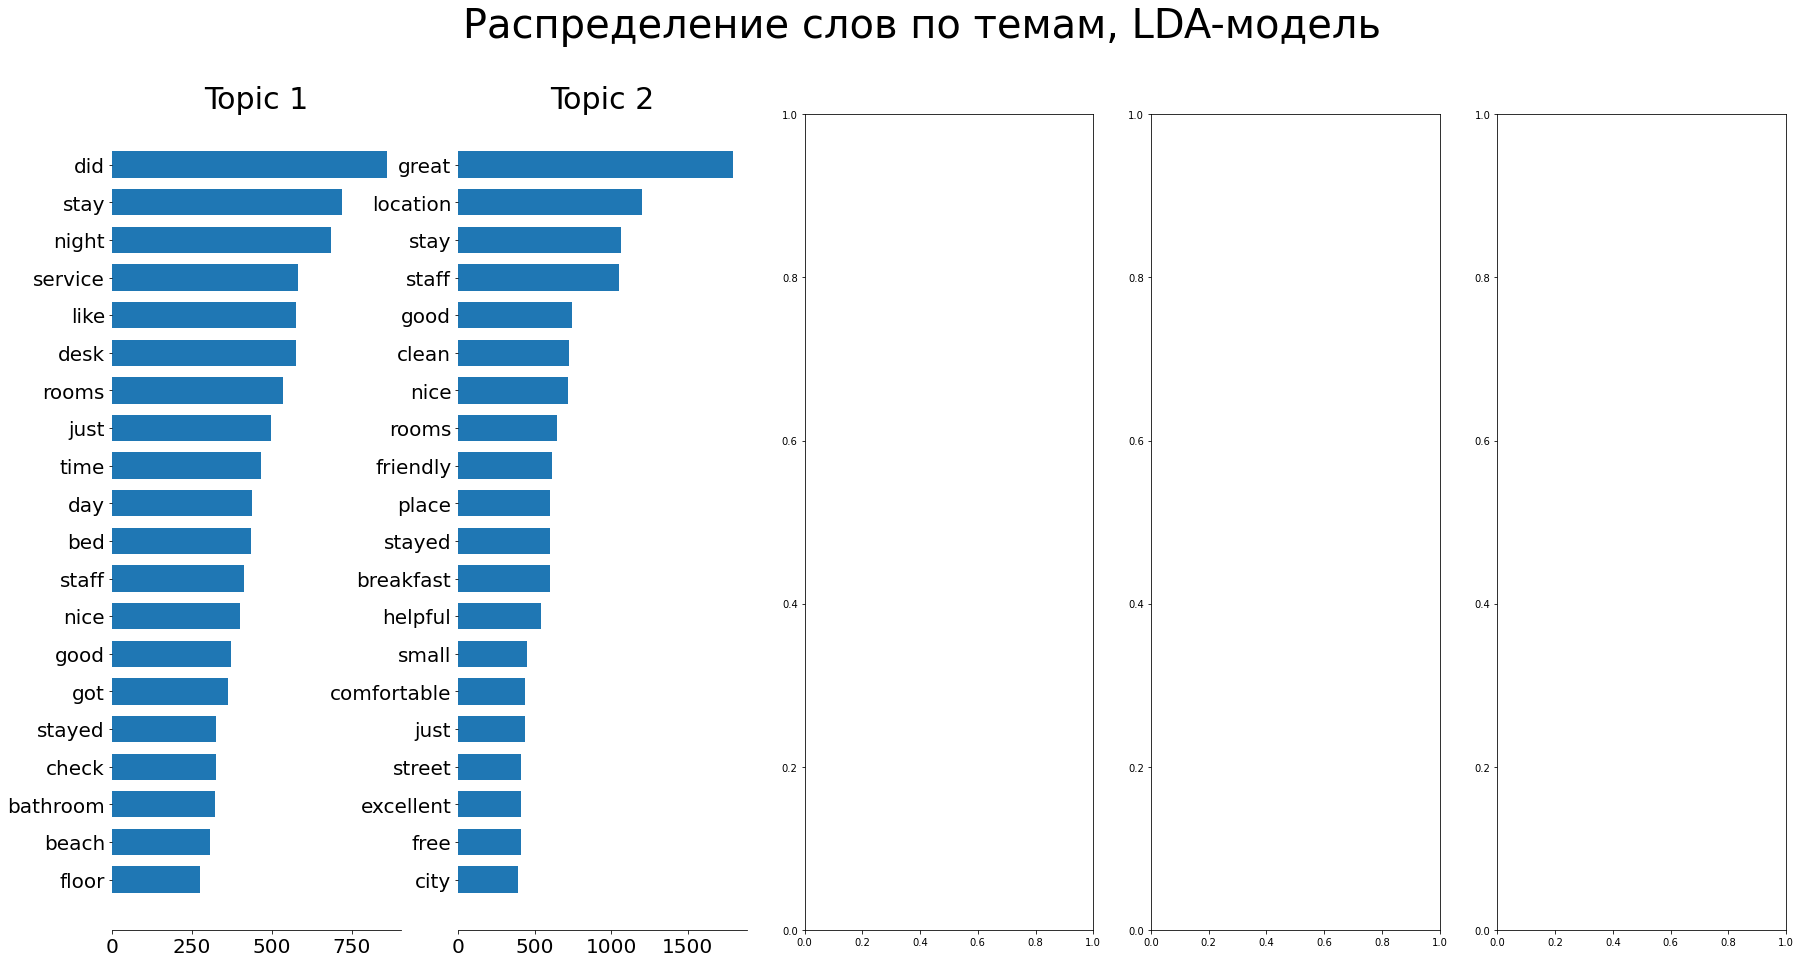

In [160]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lda, tf_feature_names, n_top_words,
               'Распределение слов по темам, LDA-модель')

**теперь посмотрим на распределение документов по темам**

In [158]:
# можно  сделать матрицу
doc_topic = lda.transform(X_tf)

print(doc_topic.shape)
pd.DataFrame(doc_topic).head()

(2000, 2)


,0,1
0,0.715379,0.284621
1,0.912918,0.087082
2,0.916700,0.083300
3,0.233512,0.766488
4,0.687269,0.312731


In [159]:
#можно поместить попарно в словарь
docs_x_topics= {}

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()+1
    docs_x_topics[n] = topic_most_pr
    
len(docs_x_topics)
docs_x_topics.items()

dict_items([(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 2), (8, 2), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 2), (23, 2), (24, 2), (25, 1), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 1), (33, 2), (34, 2), (35, 2), (36, 1), (37, 2), (38, 2), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 2), (55, 2), (56, 2), (57, 2), (58, 2), (59, 2), (60, 2), (61, 2), (62, 2), (63, 2), (64, 2), (65, 1), (66, 2), (67, 1), (68, 2), (69, 1), (70, 2), (71, 1), (72, 2), (73, 2), (74, 2), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 2), (85, 2), (86, 2), (87, 1), (88, 1), (89, 1), (90, 2), (91, 2), (92, 1), (93, 2), (94, 2), (95, 2), (96, 2), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 2), (103, 1), (104, 2), (105, 2), (106, 1), (107, 2), (108, 1), (109, 1)

# Остальные методы

## SVD

LSA(Latent Semantic Analysis) - это метод сокращения размерности для текстовых данных, который использует сингулярное разложение (SVD) для выявления скрытой структуры в данных.

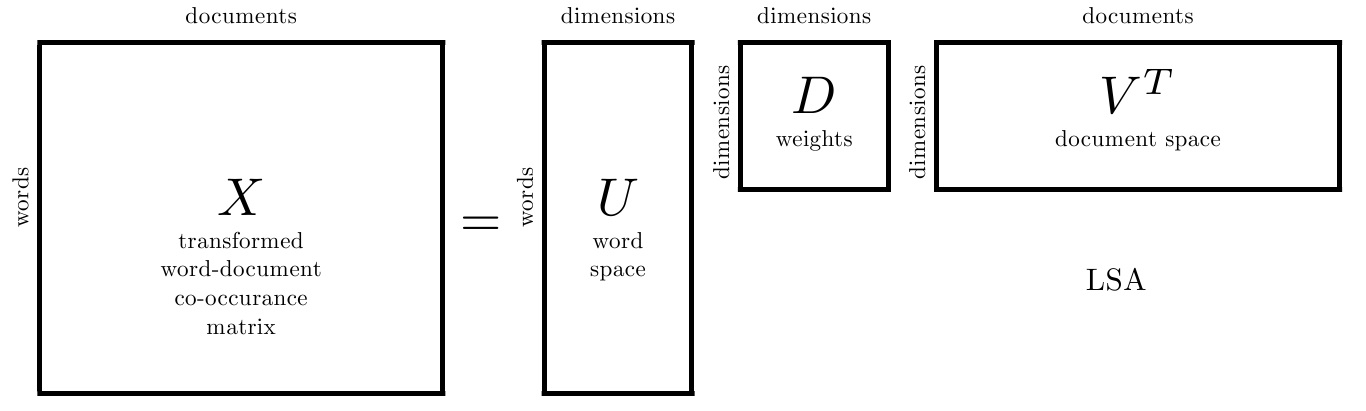

Первый шаг в LSA - построение матрицы ```"слова x документы"``` (она у нас готова и лежит в переменной ```X_tf```)
Затем SVD используется для разложения ```"слова x документы"``` на составляющие (aka три другие матрицы: ```"слова x темы"```, ```"темы х темы"```,  ```"темы х документы"```)

**А как матрица "разлагается"?**


1. Сначала из матрицы X получаем транспонированную матрицу X^T.
2. Вычисляем произведение матриц X^T * X.
3. Находим собственные значения и собственные векторы матрицы полученной из предыдущего шага( X^T * X).
4. Отсортируем собственные значения в порядке убывания и сформируем диагональную матрицу D( ```"темы х темы"```), в которой на диагонали будут располагаться собственные значения.
5. Вычислим матрицу U(```"слова x темы"```), взяв собственные векторы матрицы X^T * X, соответствующие собственным значениям в D. Собственные векторы нормализуются таким образом, чтобы ||u_i|| = 1, где u_i - i-ый столбец U.
6. Вычислим матрицу V(```"темы х документы"```), взяв собственные векторы матрицы X * X^T, соответствующие ненулевым собственным значениям в D. Собственные векторы нормализуются таким образом, чтобы ||v_i|| = 1, где v_i - i-ый столбец V.
7. Матрица X может быть представлена как X = UDV^T.


[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [164]:
# обучаем модель
lsa_model = TruncatedSVD(n_components=n_components, n_iter=10)

lsa_topic_matrix = lsa_model.fit_transform(X_tf)

In [162]:
lsa_topic_matrix.shape

(2000, 5)

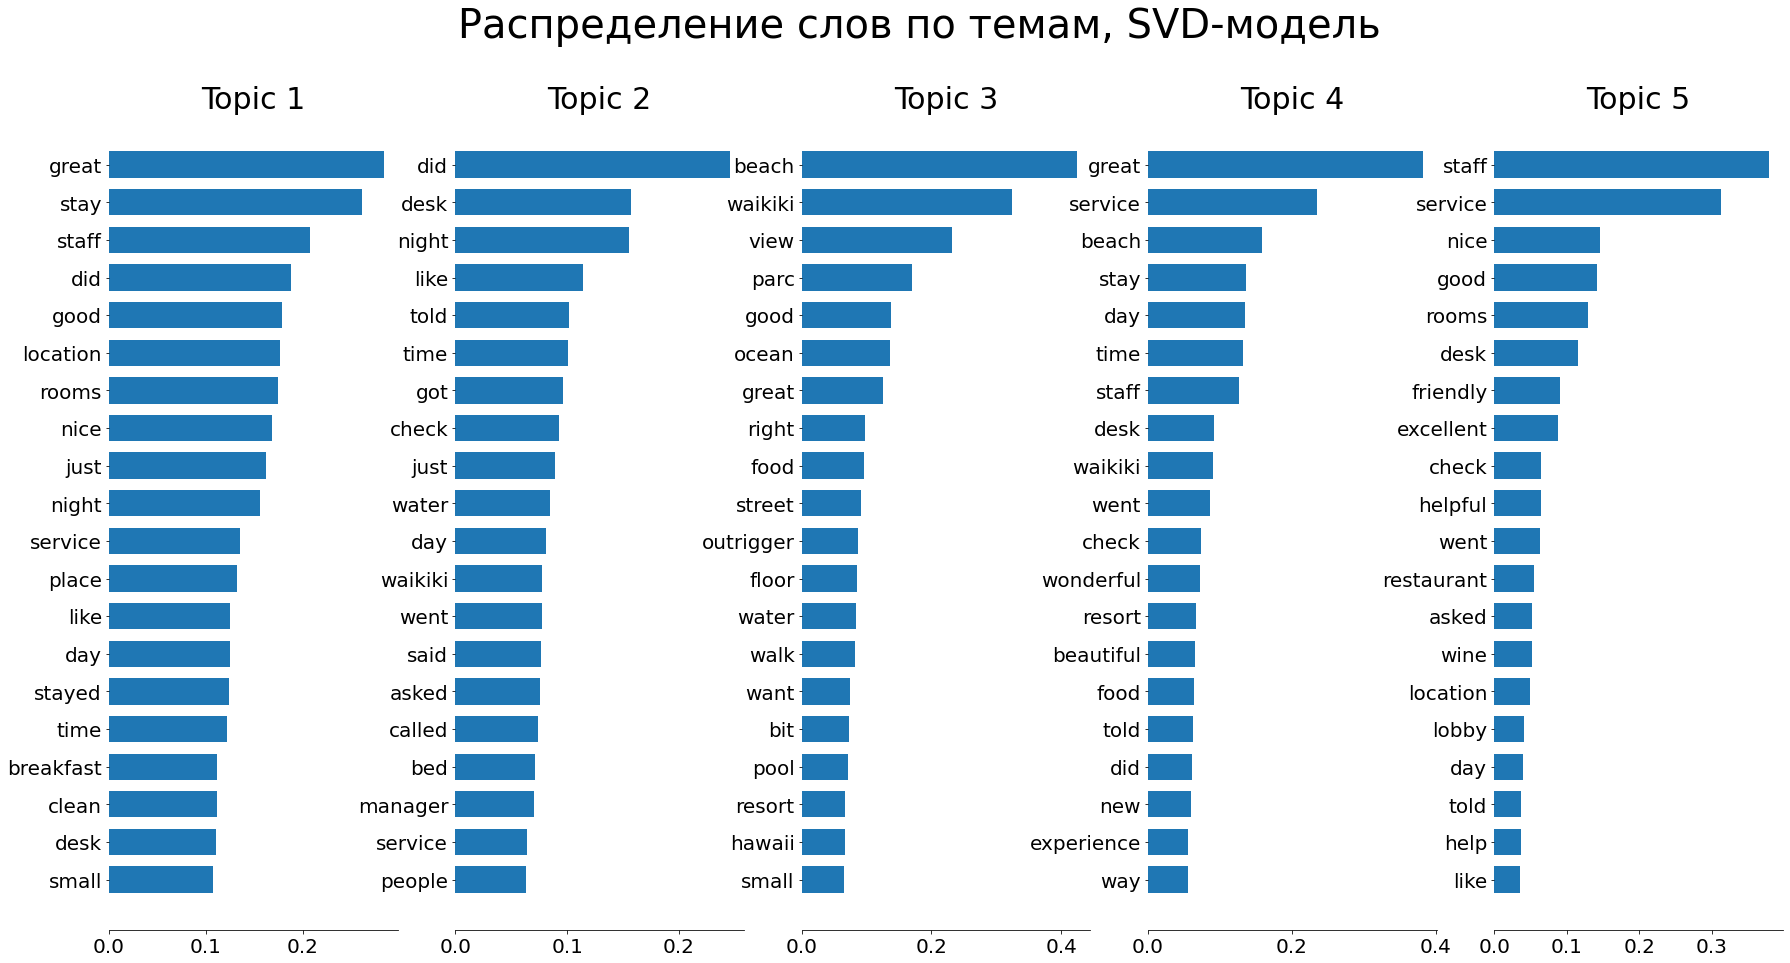

In [165]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lsa_model, tf_feature_names, n_top_words, 'Распределение слов по темам, SVD-модель')

In [166]:
for n in range(lsa_topic_matrix.shape[0]):
    topic_most_pr = lsa_topic_matrix[n].argmax()+1 
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 1

doc: 1 topic: 1

doc: 2 topic: 1

doc: 3 topic: 1

doc: 4 topic: 1

doc: 5 topic: 1

doc: 6 topic: 1

doc: 7 topic: 1

doc: 8 topic: 1

doc: 9 topic: 1

doc: 10 topic: 1

doc: 11 topic: 1

doc: 12 topic: 1

doc: 13 topic: 1

doc: 14 topic: 1

doc: 15 topic: 1

doc: 16 topic: 1

doc: 17 topic: 1

doc: 18 topic: 1

doc: 19 topic: 1

doc: 20 topic: 1

doc: 21 topic: 1

doc: 22 topic: 1

doc: 23 topic: 1

doc: 24 topic: 1

doc: 25 topic: 1

doc: 26 topic: 1

doc: 27 topic: 1

doc: 28 topic: 1

doc: 29 topic: 1

doc: 30 topic: 1

doc: 31 topic: 1

doc: 32 topic: 1

doc: 33 topic: 1

doc: 34 topic: 1

doc: 35 topic: 1

doc: 36 topic: 1

doc: 37 topic: 1

doc: 38 topic: 1

doc: 39 topic: 1

doc: 40 topic: 1

doc: 41 topic: 1

doc: 42 topic: 1

doc: 43 topic: 1

doc: 44 topic: 1

doc: 45 topic: 1

doc: 46 topic: 1

doc: 47 topic: 1

doc: 48 topic: 1

doc: 49 topic: 1

doc: 50 topic: 1

doc: 51 topic: 1

doc: 52 topic: 1

doc: 53 topic: 1

doc: 54 topic: 1

doc: 55 topic: 1

do

##  NMF
NMF -- альтернативный способ разложения матрицы, который подразумевает, что значения фичей не-негативные (т.е. >=0). 
NMF часто заменяет PCA. При разложении изначальная матрица превращается в две, при этом оптимизируются два параметра: расстояние между матрицами и их произведение.

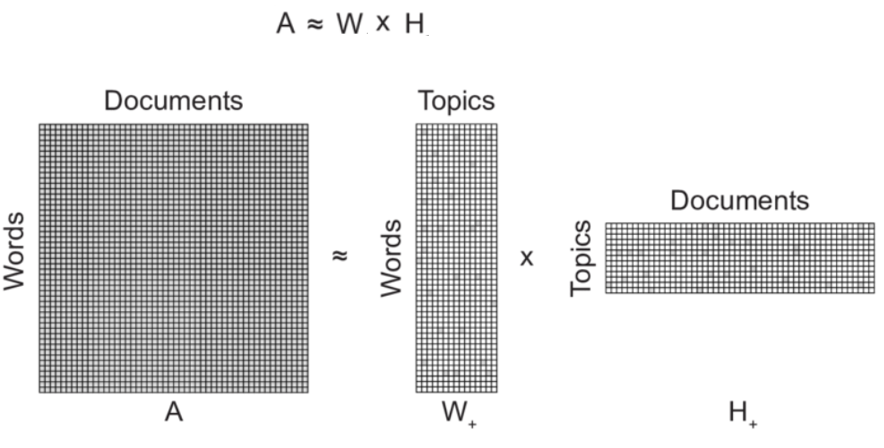

Первый шаг в NMF - факторизация матрицы данных на две неотрицательные матрицы, которые приближают исходные данные.
Затем используется итеративная оптимизация для обновления факторизации до сходимости.
Наконец, сокращение размерности выполняется путем сохранения только топ-k факторов.
NMF полезен для тематического моделирования и извлечения признаков.

[про модель](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)

In [167]:
# для NMF понадобится tf-idf-векторизация, тк tf-idf не бывает негативным

tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=3,
                                   max_features=n_features,
                                   stop_words='english')

X_tfidf = tfidf_vectorizer.fit_transform(reviews_as_list)


In [168]:
X_tfidf.shape

(2000, 1000)

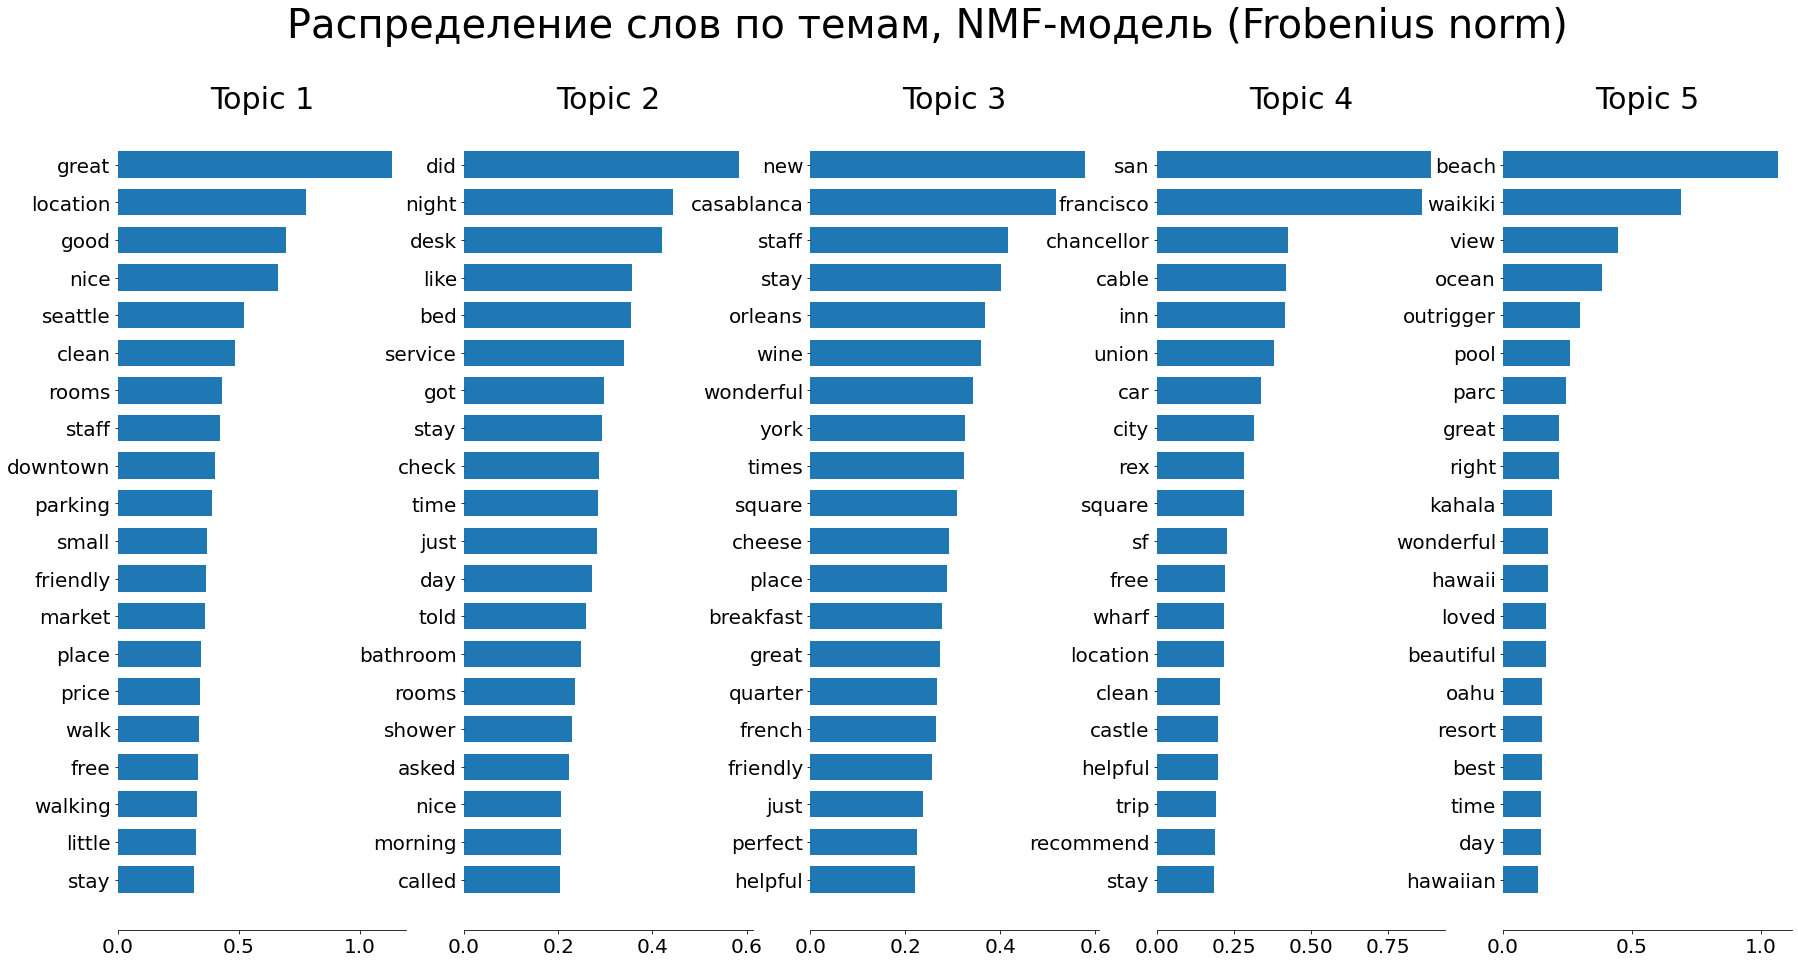

In [169]:
# обучаем первую модель

nmf = NMF(n_components=n_components).fit(X_tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение слов по темам, NMF-модель (Frobenius norm)')

Для второй версии добавим параметров:

- beta-loss : мера оптимизации расстояния между матрицами (дивергенции)
- solver: еще один параметр оптимизации, для KL-дивергенции нужен Multiplicative Update ('mu')

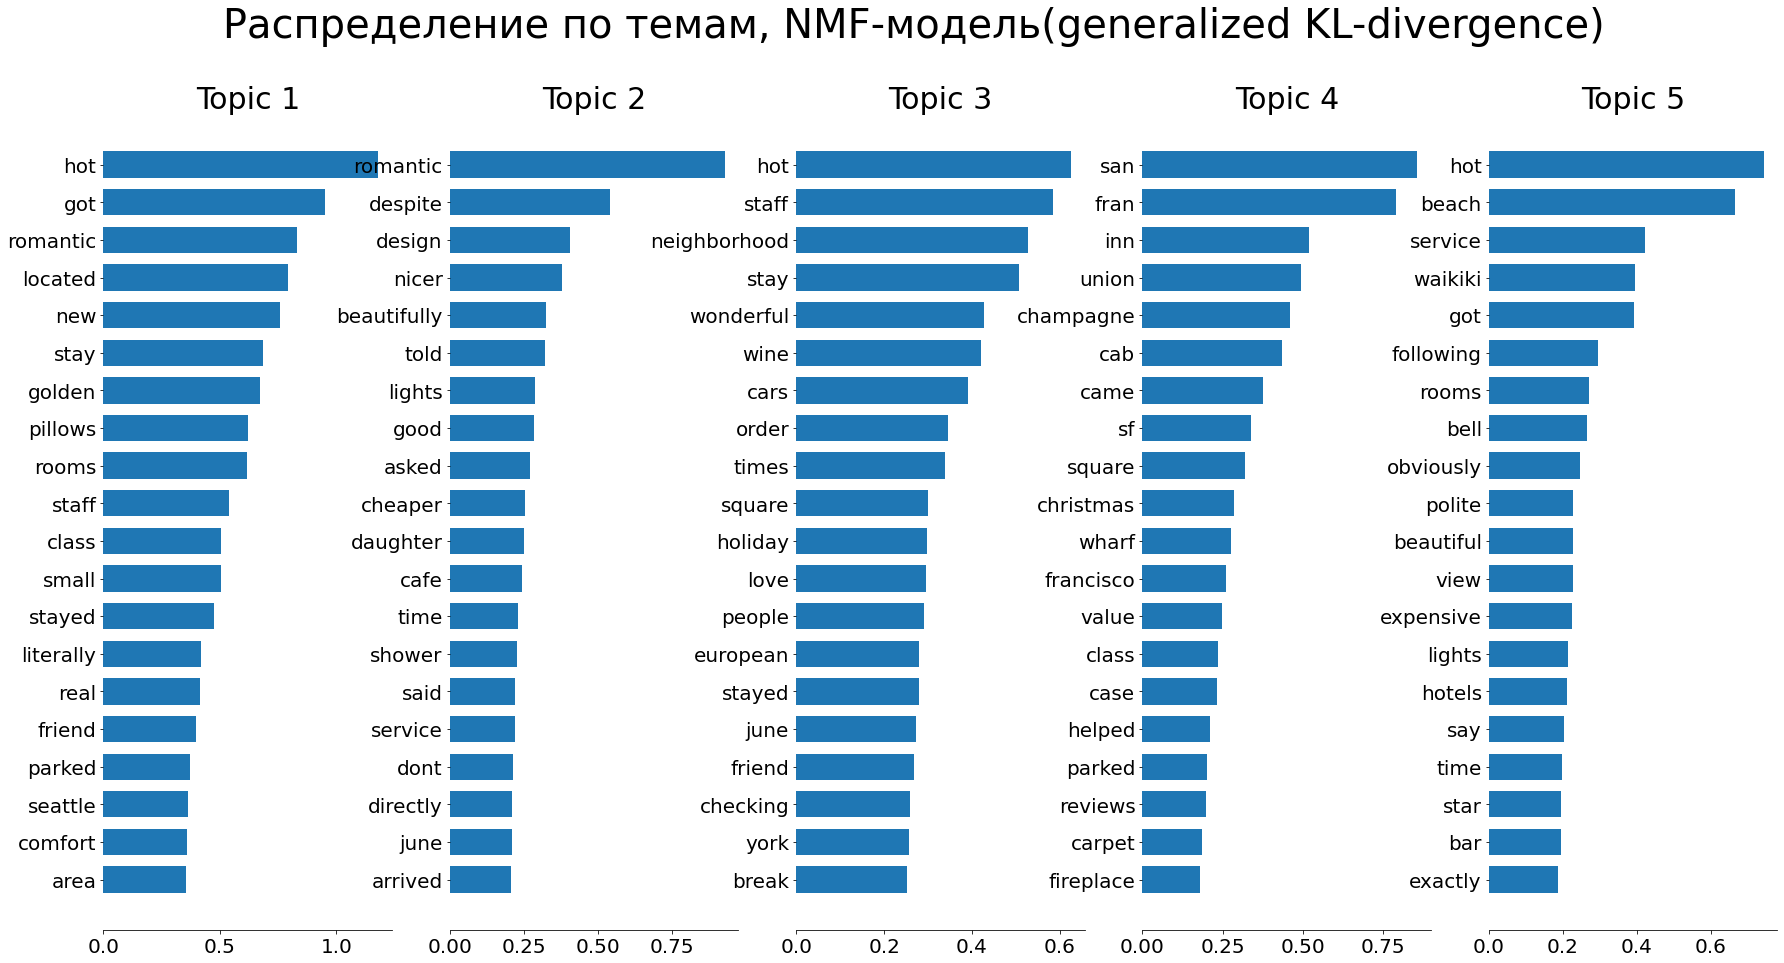

In [170]:
# обучаем вторую модель

nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', solver='mu').fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель(generalized KL-divergence)')


In [171]:
nmf_topics = nmf.transform(tfidf)

for n in range(nmf_topics.shape[0]):
    topic_most_pr = nmf_topics[n].argmax()+1 
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 2

doc: 1 topic: 2

doc: 2 topic: 2

doc: 3 topic: 1

doc: 4 topic: 2

doc: 5 topic: 3

doc: 6 topic: 1

doc: 7 topic: 5

doc: 8 topic: 1

doc: 9 topic: 3

doc: 10 topic: 5

doc: 11 topic: 2

doc: 12 topic: 1

doc: 13 topic: 2

doc: 14 topic: 1

doc: 15 topic: 2

doc: 16 topic: 2

doc: 17 topic: 2

doc: 18 topic: 1

doc: 19 topic: 2

doc: 20 topic: 1

doc: 21 topic: 3

doc: 22 topic: 1

doc: 23 topic: 1

doc: 24 topic: 1

doc: 25 topic: 2

doc: 26 topic: 3

doc: 27 topic: 1

doc: 28 topic: 1

doc: 29 topic: 1

doc: 30 topic: 1

doc: 31 topic: 1

doc: 32 topic: 2

doc: 33 topic: 1

doc: 34 topic: 1

doc: 35 topic: 1

doc: 36 topic: 1

doc: 37 topic: 1

doc: 38 topic: 1

doc: 39 topic: 1

doc: 40 topic: 2

doc: 41 topic: 1

doc: 42 topic: 2

doc: 43 topic: 5

doc: 44 topic: 2

doc: 45 topic: 2

doc: 46 topic: 2

doc: 47 topic: 2

doc: 48 topic: 1

doc: 49 topic: 1

doc: 50 topic: 1

doc: 51 topic: 1

doc: 52 topic: 1

doc: 53 topic: 1

doc: 54 topic: 1

doc: 55 topic: 1

do

Какой алгоритм тематического моделирования оказался лучше всего?

## А как выбрать лучший алгоритм для моих данных?

Выбор между Latent Semantic Analysis (LSA), Latent Dirichlet Allocation (LDA) и Non-negative Matrix Factorization (NMF) зависит от конкретных характеристик данных и целей анализа. Вот некоторые соображения, которые нужно учитывать:

LSA - хороший выбор, когда данные представлены в виде матрицы терминов-документов, и цель состоит в выявлении скрытых тем или концепций. LSA эффективно выявляет общие темы в корпусе документов, но не моделирует генеративный процесс документов.

LDA - хороший выбор, когда цель состоит в моделировании генеративного процесса корпуса документов и выявлении скрытых тем. LDA - это вероятностная модель, которая может идентифицировать сложные тематические структуры, и она показала хорошие результаты на широком диапазоне наборов данных. Однако ее обучение может быть вычислительно затратным и требует тщательного выбора гиперпараметров.

NMF - хороший выбор, когда данные неотрицательны, и цель состоит в выявлении скрытых паттернов или особенностей. NMF может использоваться для выявления частей, составляющих представление данных, и применяется в различных областях, включая анализ изображений и текстов. Однако NMF не моделирует генеративный процесс данных и может не подходить для всех типов данных.

В целом рекомендуется попробовать несколько методов и сравнить их производительность на валидационном наборе. Выбор метода может также зависеть от конкретных целей анализа и интерпретируемости результатов.